Group Members: Dhruv, Rohan, Sarthak, Uday

In [1]:
# !pip install yahoofinance
# !pip install hmmlearn
# !pip install seaborn

In [1]:
%load_ext autoreload
%autoreload 2

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.getcwd() + '/modules')
import seaborn as sns

from modules.cross_validation import Pipeline, CustomCrossValidation
from modules.directional_change import *
from modules.hidden_markov_model import make_regime_plots
from modules.logistic_regression import do_all_LR
from modules.MixtureModels import *
from modules.NaiveBayesClassifier import *
from modules.svm import do_all_SVM
from modules.timeseries import *
from modules.trading_strategy import *
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set_theme()

# Experiments

Put self-contained code here for different experiments run. Easier to put in the report that way.

# Pipeline With Cross-Validation

In [3]:
""" Grid for hyperparameter tuning """

parameter_grid = {
    'theta': np.arange(0.01, stop=0.021, step=0.005),
    'DC_indicator': ['R', 'TMV', 'T'],
    'epsilon': [0.6, 0.65, 0.7, 0.75, 0.8]
}

In [4]:
""" Pull data and run the grid search. We want to maximize profit. """

trading_day = {'equity':12, 'fx':12,'bond':12}
df_ts = get_data('^GSPC', start_date='2005-01-01', delta=trading_day['equity'])
cv = CustomCrossValidation(pipeline_class=Pipeline, parameter_grid=parameter_grid, verbose=True)
cv.fit(data = df_ts, metric='profit', minimize=False)

[*********************100%***********************]  1 of 1 completed
Iteration: 1 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'theta': 0.01}
Iteration: 1 of 45: Training complete.
Iteration: 1 of 45: Loss: {'drawdown': 0.1305995614876654, 'profit': 0.11294466215834031, 'sharpe': 0.45221807530971014}
Iteration: 2 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'theta': 0.015}
Iteration: 2 of 45: Training complete.
Iteration: 2 of 45: Loss: {'drawdown': 0.13110416467530533, 'profit': 0.09080363474279118, 'sharpe': 0.30836236577557885}
Iteration: 3 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'theta': 0.019999999999999997}
Iteration: 3 of 45: Training complete.
Iteration: 3 of 45: Loss: {'drawdown': 0.14305879638395586, 'profit': 0.08665954285897826, 'sharpe': 0.2944372978219167}
Iteration: 4 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.65, 'theta': 0.01}
Iteration: 4 of 45: Training complete.
Iteration: 4 of 45: Loss: {'drawdown': 0.095926414383

In [5]:
""" Optimal parameters and optimal value of the loss function. """

cv.get_optimal_loss()

{'drawdown': 0.08494409644887346,
 'profit': 0.3578784282703851,
 'sharpe': 0.8304325174124405,
 'parameters': {'DC_indicator': 'R', 'epsilon': 0.8, 'theta': 0.01}}

In [6]:
""" Fit the model with the optimal parameters found. """

regime_trade = Pipeline(df_ts= df_ts, **cv.get_optimal_parameters())
regime_trade.fit(verbose = True)

Total duration of time: 407764800.0
Total duration spent in Regime 1: 162172800.0
Proportion of time spent in Regime 1: 0.3977116219938553
Flipping labels between regimes.


In [7]:
""" Confirm that the trading metrics match. """
regime_trade.trading_metrics

{'drawdown': 0.08494409644887346,
 'profit': 0.3578784282703851,
 'sharpe': 0.8304325174124405}

In [8]:
""" Fit the same model for the control trading strategy."""

control = Pipeline(df_ts= df_ts, strat='control', **cv.get_optimal_parameters())
control.fit(plot=False, verbose = True)

Total duration of time: 407764800.0
Total duration spent in Regime 1: 162172800.0
Proportion of time spent in Regime 1: 0.3977116219938553
Flipping labels between regimes.


In [9]:
""" Confirm that there is an improvement when we use the regimes. """

control.trading_metrics

{'drawdown': 0.10658049858278516,
 'profit': 0.13305612063278272,
 'sharpe': 0.3877989114498797}

In [10]:
""" If you want to look at all the grid search results. """
# sorted(cv.get_losses(), key=lambda d: d['profit'])

' If you want to look at all the grid search results. '

In [11]:
""" Run the control strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control', **cv.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 407764800.0
Total duration spent in Regime 1: 162172800.0
Proportion of time spent in Regime 1: 0.3977116219938553
Flipping labels between regimes.


{'drawdown': 0.1543405840247128,
 'profit': 0.37101175204318526,
 'sharpe': 0.47998209967808686}

In [12]:
""" Run the control2 strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control2', **cv.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 407764800.0
Total duration spent in Regime 1: 162172800.0
Proportion of time spent in Regime 1: 0.3977116219938553
Flipping labels between regimes.


{'drawdown': 0.15456424726434365,
 'profit': 0.3541043469635792,
 'sharpe': 0.5213167068175325}

In [13]:
""" Run the strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, **cv.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 407764800.0
Total duration spent in Regime 1: 162172800.0
Proportion of time spent in Regime 1: 0.3977116219938553
Flipping labels between regimes.


{'drawdown': 0.25057140523989796,
 'profit': 1.0823749162355516,
 'sharpe': 1.210407488924396}

In [14]:
""" If you want to get the results in Latex """
# print(cv.get_results_in_latex('Naive Bayes Cross-Validation Results'))

' If you want to get the results in Latex '

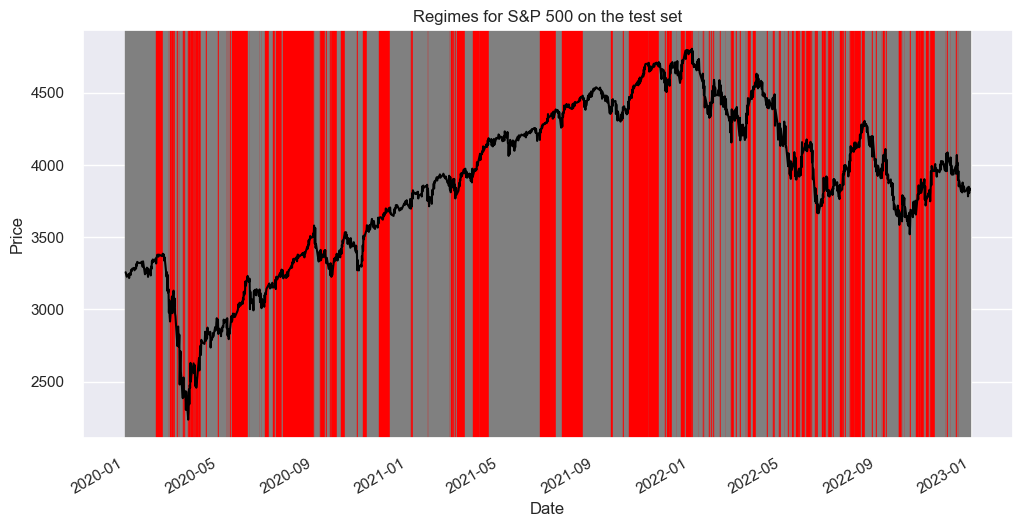

In [15]:
""" Plot our predicted regimes on the test set. """

regimes = strat_test.regimes_test

fig, ax = plt.subplots(figsize=(12,6))
df_ts["2020-01-01":].plot(ax=ax, color='black')
clr = {0:'grey',1:'red',2:'green'}

# assume default before we see any change
ax.axvspan('2020-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2022-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"Regimes for S&P 500 on the test set")
ax.set_ylabel("Price")
plt.show()

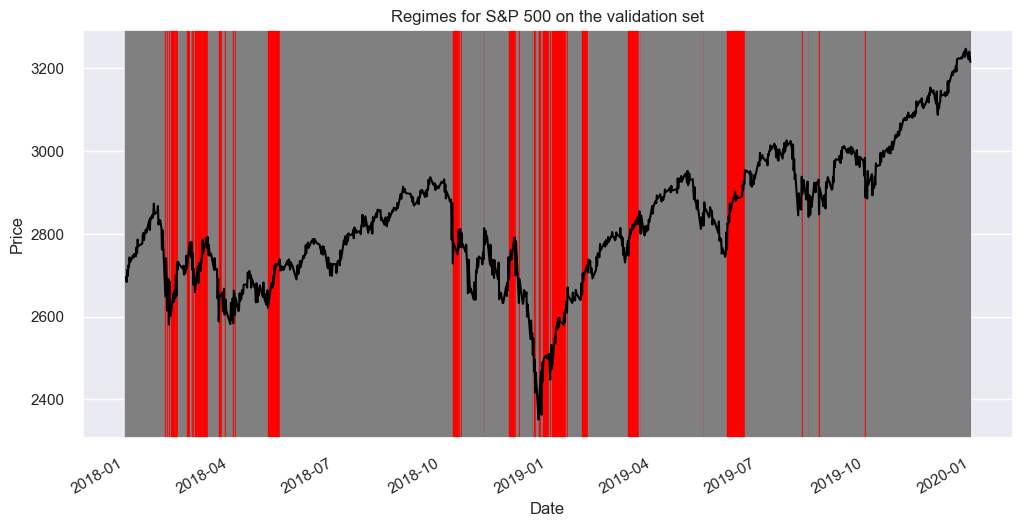

In [16]:
""" Plot our predicted regimes on the validation set. """

regimes = strat_test.regimes_valid

fig, ax = plt.subplots(figsize=(12,6))
df_ts["2018-01-01":"2019-12-31"].plot(ax=ax, color='black')
clr = {0:'grey',1:'red'}

# assume default before we see any change
ax.axvspan('2018-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at the regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2019-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"Regimes for S&P 500 on the validation set")
ax.set_ylabel("Price")
plt.show()

## Visualizing DC indicators

In [17]:
model = Pipeline(df_ts= df_ts, **cv.get_optimal_parameters())
model.fit()

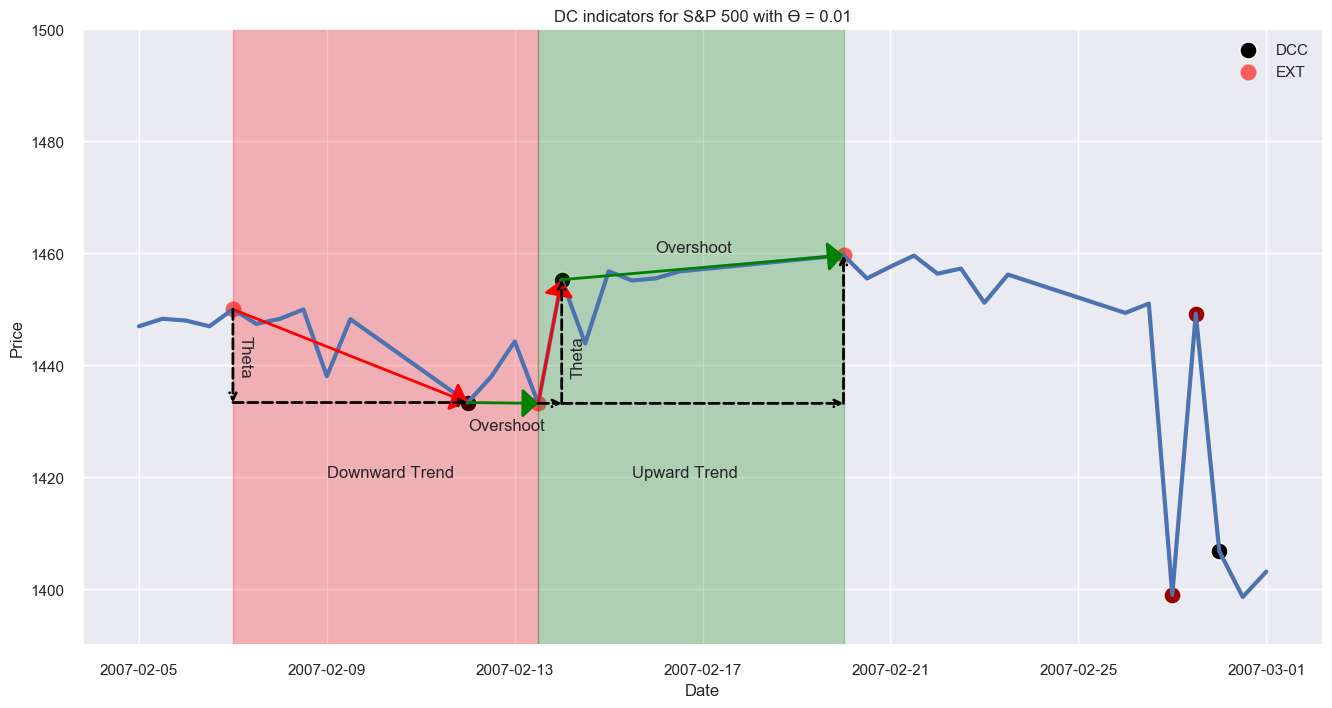

In [18]:
# example
sample_ts = df_ts[1050:1085]
first_date = sample_ts.index[0]
last_date = sample_ts.index[-1]

dcc = []
dcc_idx = []
ext = []
ext_idx = []

for i in range(len(model.dc['train'])):
    dcc.append(model.dc['train'][i][1])
    dcc_idx.append(model.dc['train'][i][0])
    ext.append( model.dc['train'][i][3] )
    ext_idx.append( model.dc['train'][i][2] )

dcc = pd.Series( data=dcc, index = dcc_idx)
ext = pd.Series( data=ext, index = ext_idx)

sample_dcc = dcc.loc[first_date:last_date]#.index
sample_ext = ext.loc[first_date:last_date]#.index

fig,ax = plt.subplots(figsize=(16,8))
features = model.dc['train']
sns.lineplot(data=sample_ts, linewidth=3)
sns.scatterplot(x = sample_dcc.index, y = sample_dcc, color='black', s=150, label='DCC',alpha=1, ax=ax)
sns.scatterplot(x = sample_ext.index, y = sample_ext, color='red', s=150, label='EXT',alpha=0.6, ax=ax)

annotate_plot(ax, sample_ext, sample_dcc)

ax.set_title(f"DC indicators for S&P 500 with ϴ = {model.theta}")
ax.set_ylabel("Price")
ax.set_ylim([1390, 1500])
ax.legend()
plt.show()

## Regime Characteristic Plots

In [19]:
model = Pipeline(df_ts= df_ts, to_test = True, **cv.get_optimal_parameters())
model.fit()
regimes_test = strat_test.regimes_test
regimes_valid = strat_test.regimes_valid

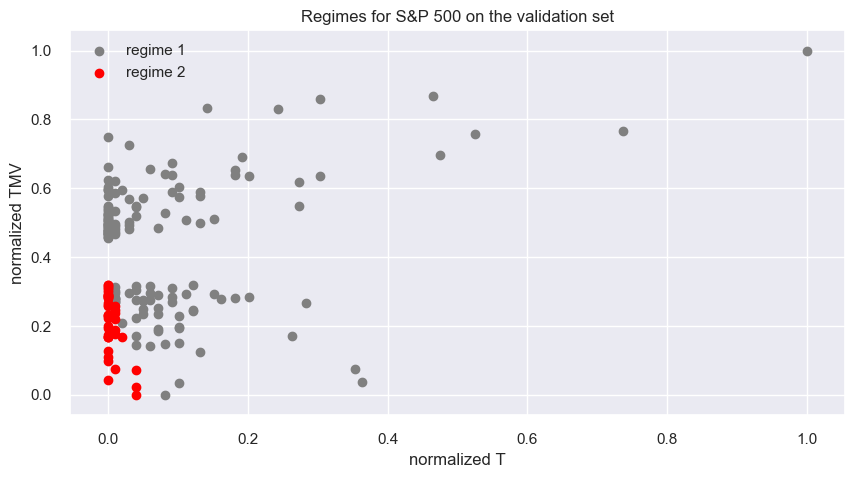

In [20]:
make_regime_plots(regimes_valid, model.tmv['valid'], model.T['valid'], 'S&P 500', 'validation')

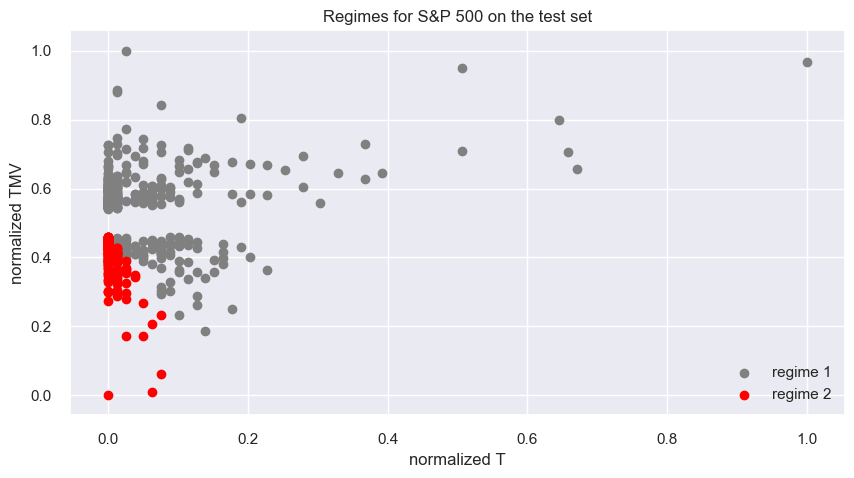

In [21]:
make_regime_plots(regimes_test, model.tmv['test'], model.T['test'], 'S&P 500', 'test')

## Comparing to Logistic Regression

In [22]:
""" Grid for hyperparameter tuning """

parameter_grid = {
    'theta': np.arange(0.01, stop=0.021, step=0.005),
    'DC_indicator': ['R', 'TMV', 'T'],
    'epsilon': [0.6, 0.65, 0.7, 0.75, 0.8],
    'model':['logistic_regression']
}

In [23]:
""" Pull data and run the grid search. We want to maximize profit. """

trading_day = {'equity':12, 'fx':12,'bond':9}
df_ts = get_data('^GSPC', start_date='2005-01-01', delta=trading_day['equity'])
cv2 = CustomCrossValidation(pipeline_class=Pipeline, parameter_grid=parameter_grid, verbose=True)
cv2.fit(data = df_ts, metric='profit', minimize=False)

[*********************100%***********************]  1 of 1 completed
Iteration: 1 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'model': 'logistic_regression', 'theta': 0.01}
Iteration: 1 of 45: Training complete.
Iteration: 1 of 45: Loss: {'drawdown': 0.15476858537838412, 'profit': 0.05660923866428269, 'sharpe': 0.27909948638735205}
Iteration: 2 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'model': 'logistic_regression', 'theta': 0.015}
Iteration: 2 of 45: Training complete.
Iteration: 2 of 45: Loss: {'drawdown': 0.16062405648755845, 'profit': 0.0879903043994934, 'sharpe': 0.3511267874220865}
Iteration: 3 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'model': 'logistic_regression', 'theta': 0.019999999999999997}
Iteration: 3 of 45: Training complete.
Iteration: 3 of 45: Loss: {'drawdown': 0.17240205914205342, 'profit': 0.07111066491993512, 'sharpe': 0.28659436450957937}
Iteration: 4 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.65, 'model': 'l

In [24]:
""" Optimal parameters and optimal value of the loss function. """

cv2.get_optimal_loss()

{'drawdown': 0.173192787639177,
 'profit': 0.21010499133694815,
 'sharpe': 0.495565497339407,
 'parameters': {'DC_indicator': 'T',
  'epsilon': 0.6,
  'model': 'logistic_regression',
  'theta': 0.019999999999999997}}

In [25]:
""" Fit the model with the optimal parameters found. """

regime_trade = Pipeline(df_ts= df_ts, **cv2.get_optimal_parameters())
regime_trade.fit(verbose = True)

Total duration of time: 396662400.0
Total duration spent in Regime 2: 319291200.0
Proportion of time spent in Regime 2: 0.8049444565454149
Flipping labels between regimes.


In [26]:
""" Confirm that the trading metrics match. """
regime_trade.trading_metrics

{'drawdown': 0.173192787639177,
 'profit': 0.21010499133694815,
 'sharpe': 0.495565497339407}

In [27]:
""" Fit the same model for the control trading strategy."""

control = Pipeline(df_ts= df_ts, strat='control', **cv2.get_optimal_parameters())
control.fit(plot=False, verbose = True)

Total duration of time: 396662400.0
Total duration spent in Regime 2: 319291200.0
Proportion of time spent in Regime 2: 0.8049444565454149
Flipping labels between regimes.


In [28]:
""" Confirm that there is an improvement when we use the regimes. """

control.trading_metrics

{'drawdown': 0.197107948275105,
 'profit': 0.05202371492608826,
 'sharpe': 0.23050795640032237}

In [29]:
""" Run the control strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control', **cv2.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 2: 319291200.0
Proportion of time spent in Regime 2: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.2701506503824544,
 'profit': 0.40691312858269235,
 'sharpe': 0.46022959091991317}

In [30]:
""" Run the control2 strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control2', **cv2.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 2: 319291200.0
Proportion of time spent in Regime 2: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.25873230856297735,
 'profit': 0.5019380257164072,
 'sharpe': 0.6115277904174444}

In [31]:
""" Run the strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, **cv2.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 2: 319291200.0
Proportion of time spent in Regime 2: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.21378587832646642,
 'profit': 0.7527669340261292,
 'sharpe': 0.752857105770566}

In [32]:
""" If you want to get the results in Latex """
# print(cv2.get_results_in_latex(
#     loss_columns=['profit', 'drawdown', 'sharpe'],
#     parameter_columns=['theta', 'epsilon', 'DC_indicator'],
#     caption='Logistic Regression Cross-Validation Results'))

' If you want to get the results in Latex '

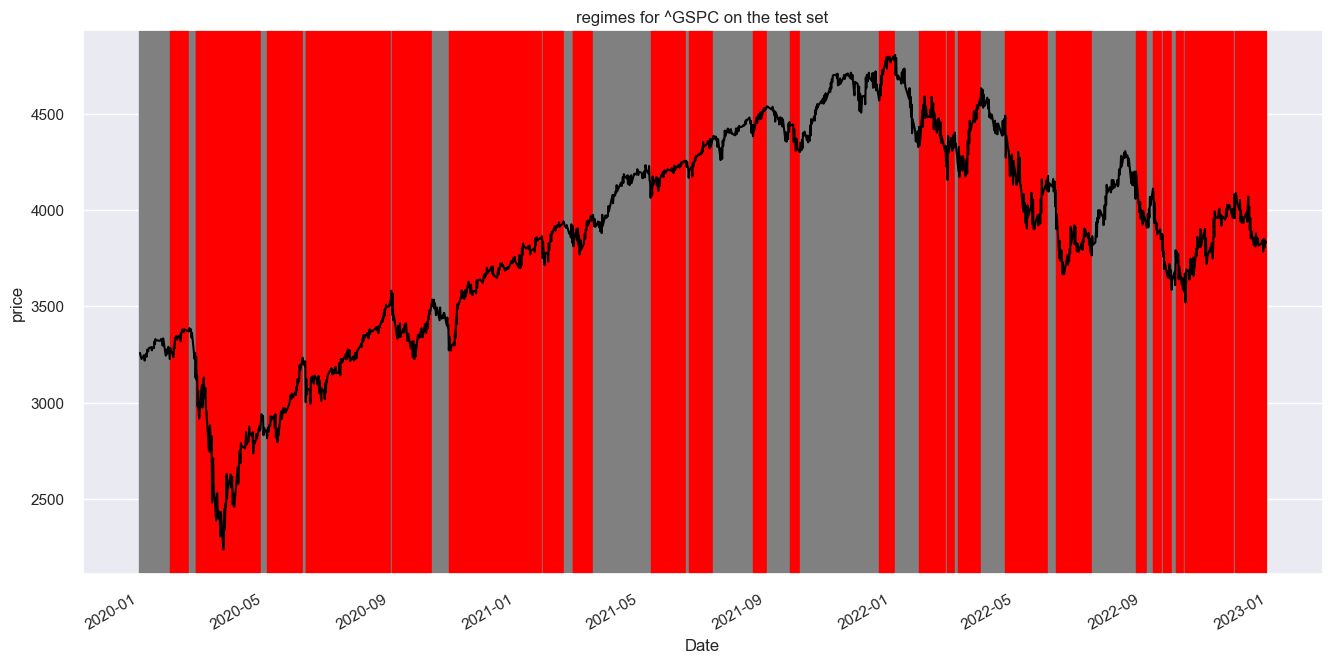

In [33]:
""" Plot our predicted regimes on the test set. """

regimes = strat_test.regimes_test

fig, ax = plt.subplots(figsize=(16,8))
df_ts["2020-01-01":].plot(ax=ax, color='black')
clr = {0:'grey',1:'red',2:'green'}

# assume default before we see any change
ax.axvspan('2020-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2022-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"regimes for {strat_test.ticker} on the test set")
ax.set_ylabel("price")
plt.show()

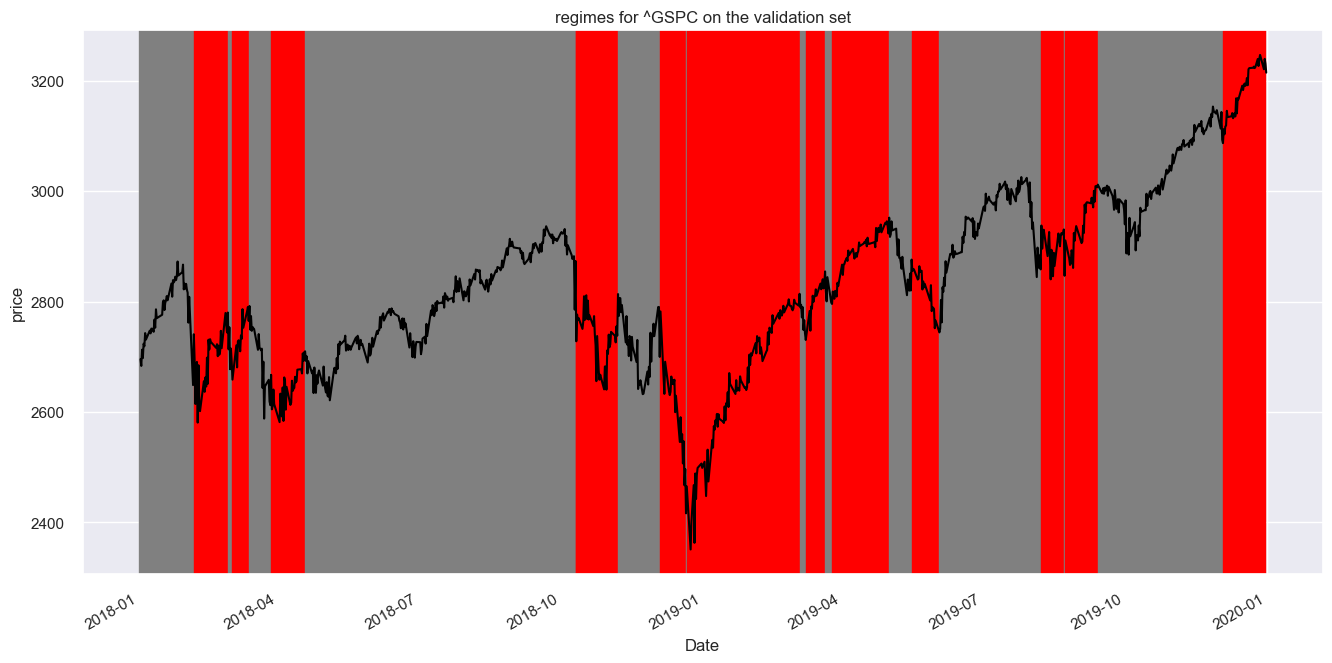

In [34]:
""" Plot our predicted regimes on the validation set. """

regimes = strat_test.regimes_valid

fig, ax = plt.subplots(figsize=(16,8))
df_ts["2018-01-01":"2019-12-31"].plot(ax=ax, color='black')
clr = {0:'grey',1:'red'}

# assume default before we see any change
ax.axvspan('2018-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at the regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2019-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"regimes for {strat_test.ticker} on the validation set")
ax.set_ylabel("price")
plt.show()

# Comparing to SVM

In [35]:
""" Grid for hyperparameter tuning """

parameter_grid = {
    'theta': np.arange(0.01, stop=0.021, step=0.005),
    'DC_indicator': ['R', 'TMV', 'T'],
    'epsilon': [0.6, 0.65, 0.7, 0.75, 0.8],
    'model':['svm']
}

In [36]:
""" Pull data and run the grid search. We want to maximize profit. """

trading_day = {'equity':12, 'fx':12,'bond':9}
df_ts = get_data('^GSPC', start_date='2005-01-01', delta=trading_day['equity'])
cv3 = CustomCrossValidation(pipeline_class=Pipeline, parameter_grid=parameter_grid, verbose=True)
cv3.fit(data = df_ts, metric='profit', minimize=False)

[*********************100%***********************]  1 of 1 completed
Iteration: 1 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'model': 'svm', 'theta': 0.01}
Iteration: 1 of 45: Training complete.
Iteration: 1 of 45: Loss: {'drawdown': 0.15476858537838412, 'profit': 0.05660923866428269, 'sharpe': 0.27909948638735205}
Iteration: 2 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'model': 'svm', 'theta': 0.015}
Iteration: 2 of 45: Training complete.
Iteration: 2 of 45: Loss: {'drawdown': 0.16062405648755845, 'profit': 0.0879903043994934, 'sharpe': 0.3511267874220865}
Iteration: 3 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'model': 'svm', 'theta': 0.019999999999999997}
Iteration: 3 of 45: Training complete.
Iteration: 3 of 45: Loss: {'drawdown': 0.17240205914205342, 'profit': 0.07111066491993512, 'sharpe': 0.28659436450957937}
Iteration: 4 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.65, 'model': 'svm', 'theta': 0.01}
Iteration: 4 of 45: Training

In [37]:
""" Optimal parameters and optimal value of the loss function. """

cv3.get_optimal_loss()

{'drawdown': 0.173192787639177,
 'profit': 0.21010499133694815,
 'sharpe': 0.495565497339407,
 'parameters': {'DC_indicator': 'T',
  'epsilon': 0.6,
  'model': 'svm',
  'theta': 0.019999999999999997}}

In [38]:
""" Fit the model with the optimal parameters found. """

regime_trade = Pipeline(df_ts= df_ts, **cv3.get_optimal_parameters())
regime_trade.fit(verbose = True)

Total duration of time: 396662400.0
Total duration spent in Regime 2: 319291200.0
Proportion of time spent in Regime 2: 0.8049444565454149
Flipping labels between regimes.


In [39]:
""" Confirm that the trading metrics match. """
regime_trade.trading_metrics

{'drawdown': 0.173192787639177,
 'profit': 0.21010499133694815,
 'sharpe': 0.495565497339407}

In [40]:
""" Fit the same model for the control trading strategy."""

control = Pipeline(df_ts= df_ts, strat='control', **cv3.get_optimal_parameters())
control.fit(plot=False, verbose = True)

Total duration of time: 396662400.0
Total duration spent in Regime 2: 319291200.0
Proportion of time spent in Regime 2: 0.8049444565454149
Flipping labels between regimes.


In [41]:
""" Confirm that there is an improvement when we use the regimes. """

control.trading_metrics

{'drawdown': 0.197107948275105,
 'profit': 0.05202371492608826,
 'sharpe': 0.23050795640032237}

In [42]:
""" Run the control strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control', **cv3.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 2: 319291200.0
Proportion of time spent in Regime 2: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.2701506503824544,
 'profit': 0.40691312858269235,
 'sharpe': 0.46022959091991317}

In [43]:
""" Run the control2 strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control2', **cv3.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 2: 319291200.0
Proportion of time spent in Regime 2: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.25873230856297735,
 'profit': 0.5019380257164072,
 'sharpe': 0.6115277904174444}

In [44]:
""" Run the strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, **cv3.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 2: 319291200.0
Proportion of time spent in Regime 2: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.21378587832646642,
 'profit': 0.7527669340261292,
 'sharpe': 0.752857105770566}

In [45]:
""" If you want to get the results in Latex """
# print(cv3.get_results_in_latex(
#     loss_columns=['profit', 'drawdown', 'sharpe'],
#     parameter_columns=['theta', 'epsilon', 'DC_indicator'],
#     caption='SVM Cross-Validation Results'))

' If you want to get the results in Latex '

2020-01-24 12:00:00    0
2020-01-31 00:00:00    1
2020-02-19 00:00:00    0
2020-02-25 00:00:00    1
2020-02-25 12:00:00    1
                      ..
2022-11-30 00:00:00    0
2022-11-30 12:00:00    1
2022-12-01 12:00:00    1
2022-12-07 12:00:00    1
2022-12-13 12:00:00    1
Length: 183, dtype: int64


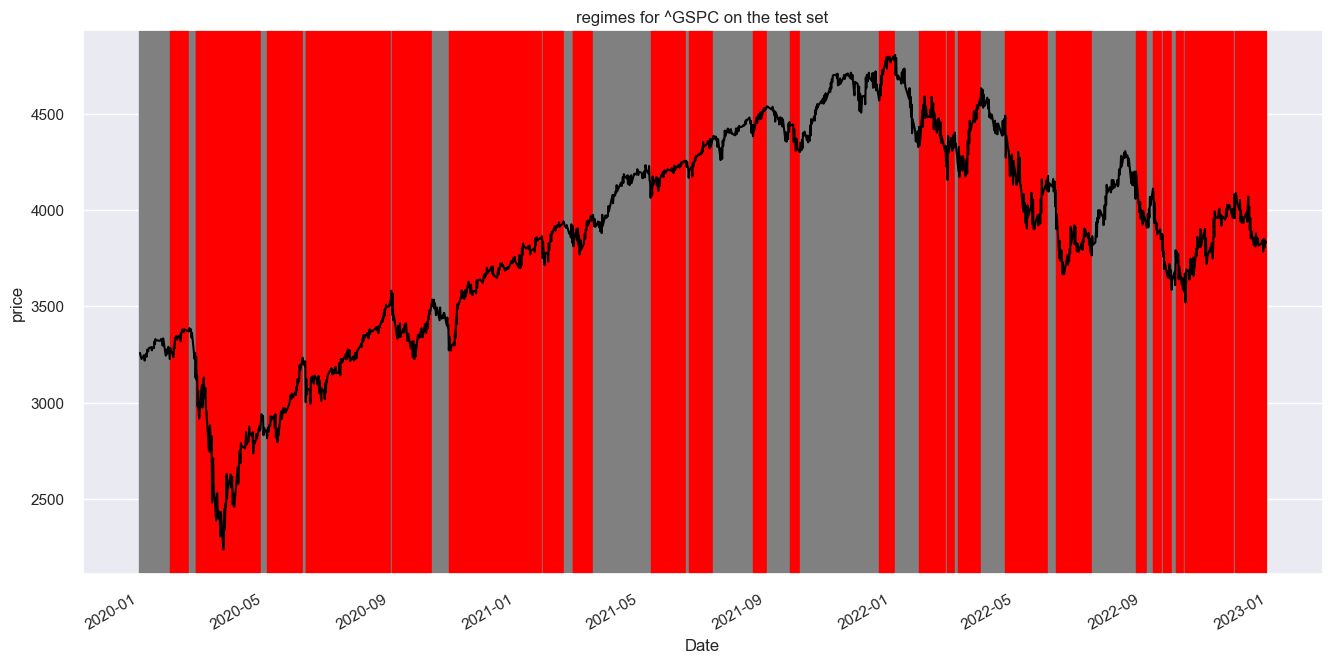

In [46]:
""" Plot our predicted regimes on the test set. """

regimes = strat_test.regimes_test

print(regimes)

fig, ax = plt.subplots(figsize=(16,8))
df_ts["2020-01-01":].plot(ax=ax, color='black')
clr = {0:'grey',1:'red',2:'green'}

# assume default before we see any change
ax.axvspan('2020-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2022-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"regimes for {strat_test.ticker} on the test set")
ax.set_ylabel("price")
plt.show()

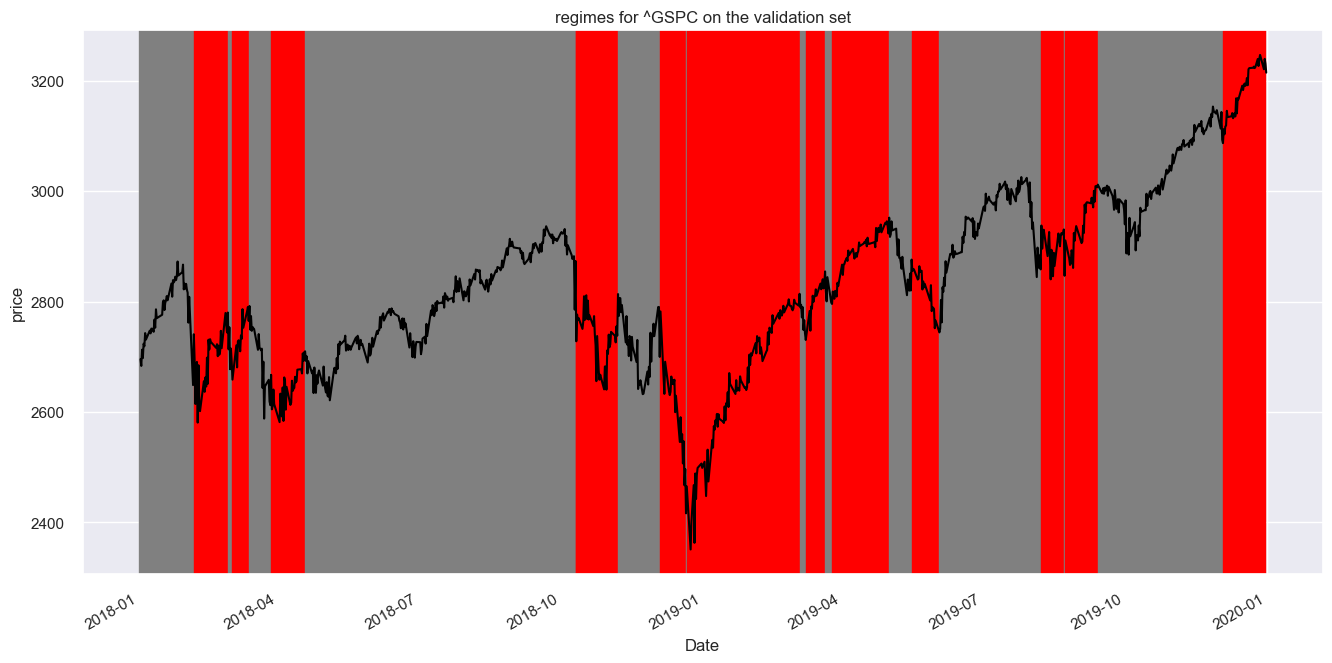

In [47]:
""" Plot our predicted regimes on the validation set. """

regimes = strat_test.regimes_valid

fig, ax = plt.subplots(figsize=(16,8))
df_ts["2018-01-01":"2019-12-31"].plot(ax=ax, color='black')
clr = {0:'grey',1:'red'}

# assume default before we see any change
ax.axvspan('2018-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at the regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2019-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"regimes for {strat_test.ticker} on the validation set")
ax.set_ylabel("price")
plt.show()

## Distribution of DCC indicator

In [48]:
model = Pipeline(df_ts= df_ts, **cv.get_optimal_parameters())
model.fit()

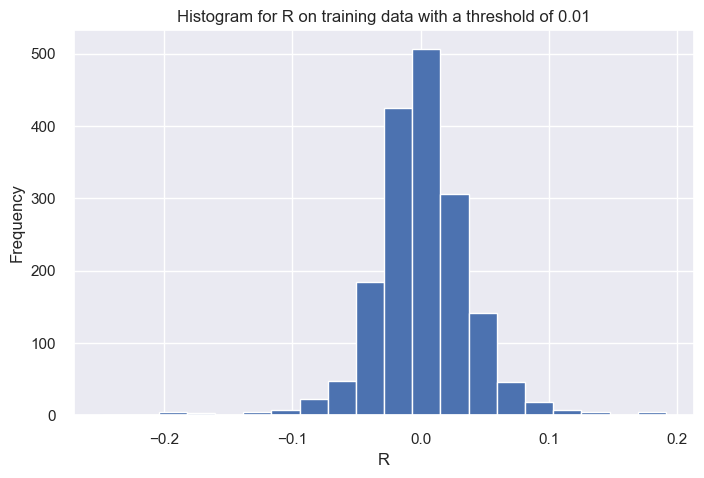

In [49]:
fig,ax = plt.subplots(figsize=(8,5))
model.R['train'].plot.hist(bins=20,ax=ax)
ax.set_title(f"Histogram for R on training data with a threshold of {cv.get_optimal_parameters()['theta']}")
ax.set_xlabel("R")
plt.show()

## Further analysis of SVM and Logistic Regression

In [85]:
""" Logistic Regression """
lr = Pipeline(df_ts= df_ts, to_test = True, **cv2.get_optimal_parameters())
lr.fit(verbose = True)
lr.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 2: 319291200.0
Proportion of time spent in Regime 2: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.21378587832646642,
 'profit': 0.7527669340261292,
 'sharpe': 0.752857105770566}

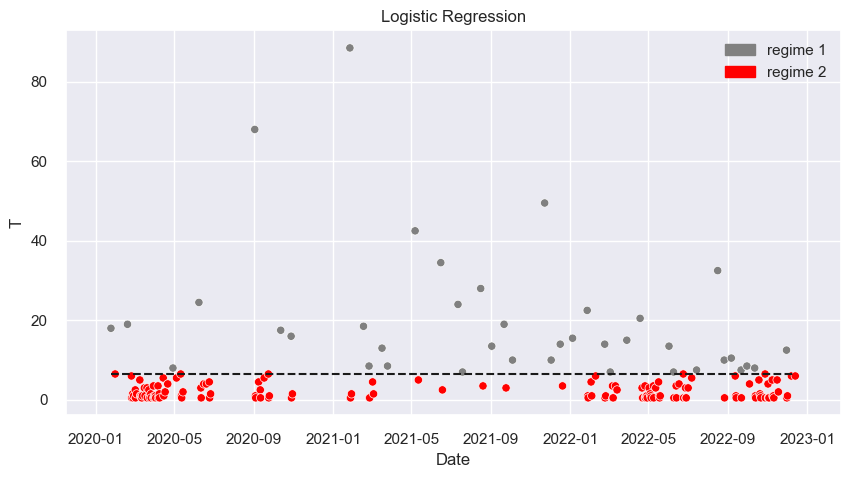

In [131]:
""" Checking linear separability for Logistic Regression on Test """
fig,ax = plt.subplots(figsize=(10,5))
sns.scatterplot(data=lr.T['test'], c=np.where(lr.regimes_test==1, 'red','gray'))
plt.hlines(np.max(lr.T['test'][lr.regimes_test==1]),xmin=lr.T['test'].index[0],xmax=lr.T['test'].index[-1], linestyles='dashed')
gray_path = mpatches.Patch(color='gray', label='regime 1')
red_patch = mpatches.Patch(color='red', label='regime 2')
plt.legend(handles=[gray_path, red_patch])
ax.set_ylabel('T')
ax.set_xlabel('Date')
ax.set_title('Logistic Regression')
None

In [89]:
""" SVM """
sv = Pipeline(df_ts= df_ts, to_test = True, **cv3.get_optimal_parameters())
sv.fit(verbose = True)
sv.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 2: 319291200.0
Proportion of time spent in Regime 2: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.21378587832646642,
 'profit': 0.7527669340261292,
 'sharpe': 0.752857105770566}

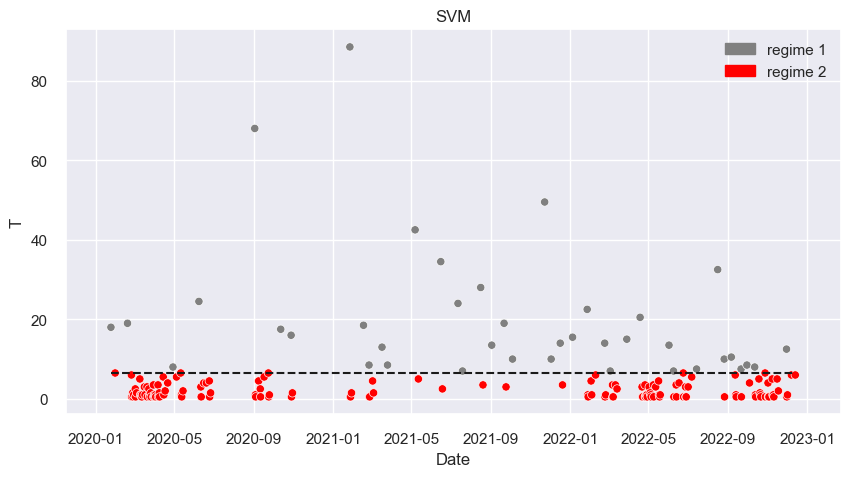

In [132]:
""" Checking linear separability for SVM Predictions on Validation """
fig,ax = plt.subplots(figsize=(10,5))
sns.scatterplot(data=sv.T['test'], c=np.where(sv.regimes_test==1, 'red','gray'))
plt.hlines(np.max(sv.T['test'][sv.regimes_test==1]),xmin=sv.T['test'].index[0],xmax=sv.T['test'].index[-1], linestyles='dashed')
gray_path = mpatches.Patch(color='gray', label='regime 1')
red_patch = mpatches.Patch(color='red', label='regime 2')
plt.legend(handles=[gray_path, red_patch])
ax.set_ylabel('T')
ax.set_xlabel('Date')
ax.set_title('SVM')
None

In [91]:
""" naive Bayes """
nb = Pipeline(df_ts= df_ts, to_test = True, **cv.get_optimal_parameters())
nb.fit(verbose = True)
nb.trading_metrics_test

Total duration of time: 407764800.0
Total duration spent in Regime 1: 162172800.0
Proportion of time spent in Regime 1: 0.3977116219938553
Flipping labels between regimes.


{'drawdown': 0.25057140523989796,
 'profit': 1.0823749162355516,
 'sharpe': 1.210407488924396}

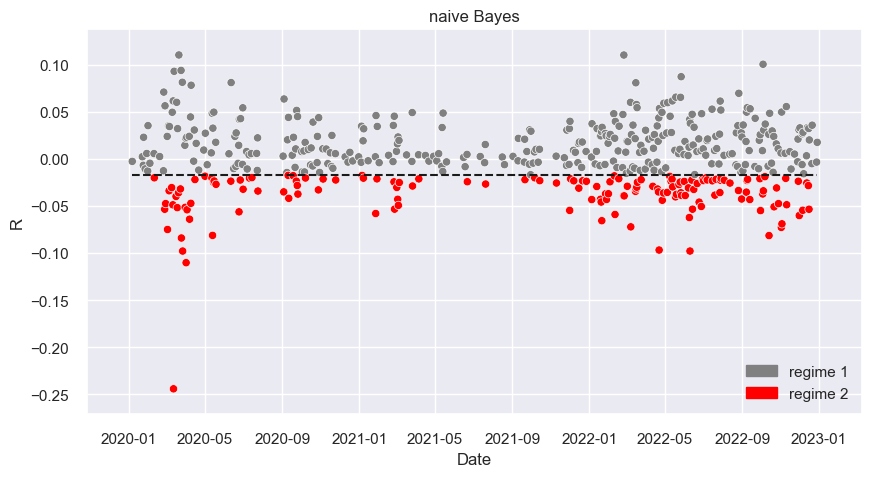

In [133]:
""" Checking linear separability for naive Bayes Predictions on Validation """
fig,ax = plt.subplots(figsize=(10,5))
sns.scatterplot(data=nb.R['test'], c=np.where(nb.regimes_test==1, 'red','gray'))
plt.hlines(np.max(nb.R['test'][nb.regimes_test==1]),xmin=nb.R['test'].index[0],xmax=nb.R['test'].index[-1], linestyles='dashed')
gray_path = mpatches.Patch(color='gray', label='regime 1')
red_patch = mpatches.Patch(color='red', label='regime 2')
plt.legend(handles=[gray_path, red_patch])
ax.set_ylabel('R')
ax.set_xlabel('Date')
ax.set_title('naive Bayes')
None

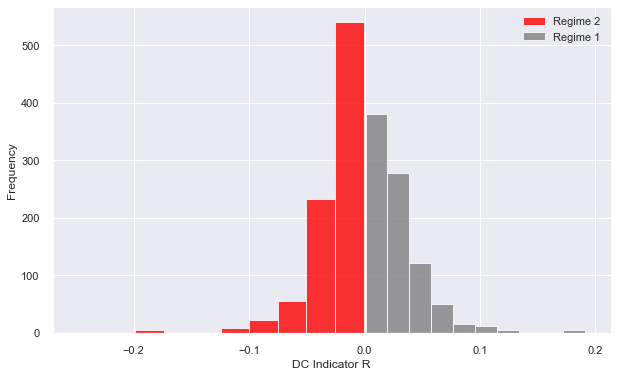

In [482]:
fig,ax = plt.subplots(figsize=(10,6))
nb.R['train'][nb.regimes == 1].plot.hist(ax=ax,alpha=0.8,color='red',label='Regime 2')
nb.R['train'][nb.regimes == 0].plot.hist(ax=ax,alpha=0.8,color='grey', label='Regime 1')
ax.legend()
ax.set_xlabel("DC Indicator R")
plt.show()

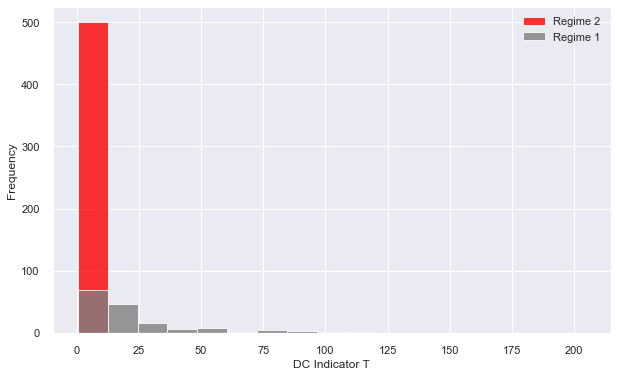

In [483]:
fig,ax = plt.subplots(figsize=(10,6))
lr.T['train'][lr.regimes == 1].plot.hist(ax=ax, bins= np.arange(lr.T['train'].min(),lr.T['train'].max(),12),alpha=0.8,color='red',label='Regime 2')
lr.T['train'][lr.regimes == 0].plot.hist(ax=ax, bins= np.arange(lr.T['train'].min(),lr.T['train'].max(),12),alpha=0.8,color='gray', label='Regime 1')
ax.legend()
ax.set_xlabel("DC Indicator T")
plt.show()